In [1]:
import datetime

from cogment_lab.envs.gymnasium import GymEnvironment
from cogment_lab.process_manager import Cogment
from cogment_lab.utils.coltra_utils import convert_trial_data_to_coltra
from cogment_lab.utils.runners import process_cleanup
from cogment_lab.utils.trial_utils import concatenate

from coltra import HomogeneousGroup
from coltra.buffers import Observation
from coltra.models import MLPModel
from coltra.policy_optimization import CrowdPPOptimizer

from cogment_lab.actors import ColtraActor

from tqdm import trange
import matplotlib.pyplot as plt


In [2]:
# Cleans up potentially hanging background processes from previous runs
process_cleanup()

Processes terminated successfully.


In [3]:
logpath = f"logs/logs-{datetime.datetime.now().isoformat()}"

cog = Cogment(log_dir=logpath)

print(logpath)

logs/logs-2023-12-13T19:24:40.452142


/Users/ariel/PycharmProjects/cogment_lab/venv/lib/python3.10/site-packages/cogment/context.py:213: UserWarning: No logging handler defined (e.g. logging.basicConfig)
  warnings.warn("No logging handler defined (e.g. logging.basicConfig)")


In [4]:
# We'll train on CartPole-v1

cenv = GymEnvironment(
    env_id="CartPole-v1",
    render=False,
)

await cog.run_env(env=cenv, 
                  env_name="cartpole",
                  port=9001, 
                  log_file="env.log")


True

In [5]:
# Create a model using coltra

model = MLPModel(
    config={
    "hidden_sizes": [64, 64],
    }, 
    observation_space=cenv.env.observation_space, 
    action_space=cenv.env.action_space
)

# Put the model in shared memory so that the actor can access it
model.share_memory()
actor = ColtraActor(model=model)


await cog.run_actor(
    actor=actor,
    actor_name="coltra",
    port=9021,
    log_file="actor.log"
)

True

In [6]:
# Check what's running

cog.processes

{'cartpole': <SpawnProcess name='SpawnProcess-1' pid=17503 parent=17470 started>,
 'coltra': <SpawnProcess name='SpawnProcess-2' pid=17509 parent=17470 started>}

In [7]:
ppo = CrowdPPOptimizer(HomogeneousGroup(actor.agent), config={
    "gae_lambda": 0.95,
    "minibatch_size": 128,
})

In [9]:
all_rewards = []

for t in (pbar := trange(10)):
    num_steps = 0
    episodes = []
    while num_steps < 1000:  # Collect at least 1000 steps per training iteration
        trial_id = await cog.start_trial(
            env_name="cartpole",
            session_config={"render": False},
            actor_impls={
                "gym": "coltra",
            },
        )
        multi_data = await cog.get_trial_data(trial_id=trial_id, env_name="cartpole")
        data = multi_data["gym"]
        episodes.append(data)
        num_steps += len(data.rewards)
        
    all_data = concatenate(episodes)

    # Preprocess data
    record = convert_trial_data_to_coltra(all_data, actor.agent)

    # Run a PPO step
    metrics = ppo.train_on_data({"crowd": record}, shape=(1,) + record.reward.shape)
    
    mean_reward = metrics["crowd/mean_episode_reward"]
    all_rewards.append(mean_reward)
    pbar.set_description(f"mean_reward: {mean_reward:.3}")

mean_reward: 27.6: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


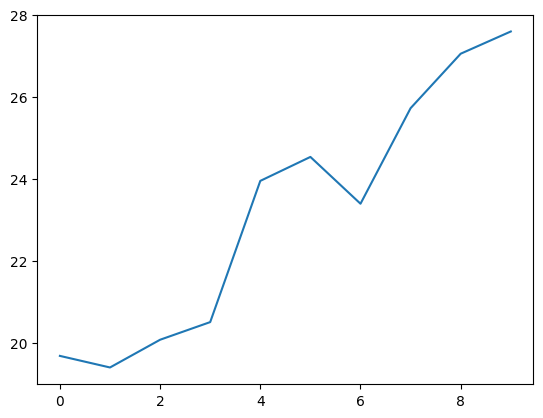

In [10]:
plt.plot(all_rewards)